<a href="https://colab.research.google.com/github/rishi12jn/Disease-Prediction/blob/main/Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 13.5 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

In [9]:
data = pd.read_csv("/content/Training.csv").dropna(axis=1)
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
print("Missing Values:", data.isnull().sum().sum())
print("First Few Rows:")
print(data.head())

Dataset Shape: (4920, 133)
Columns: Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)
Missing Values: 0
First Few Rows:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_p

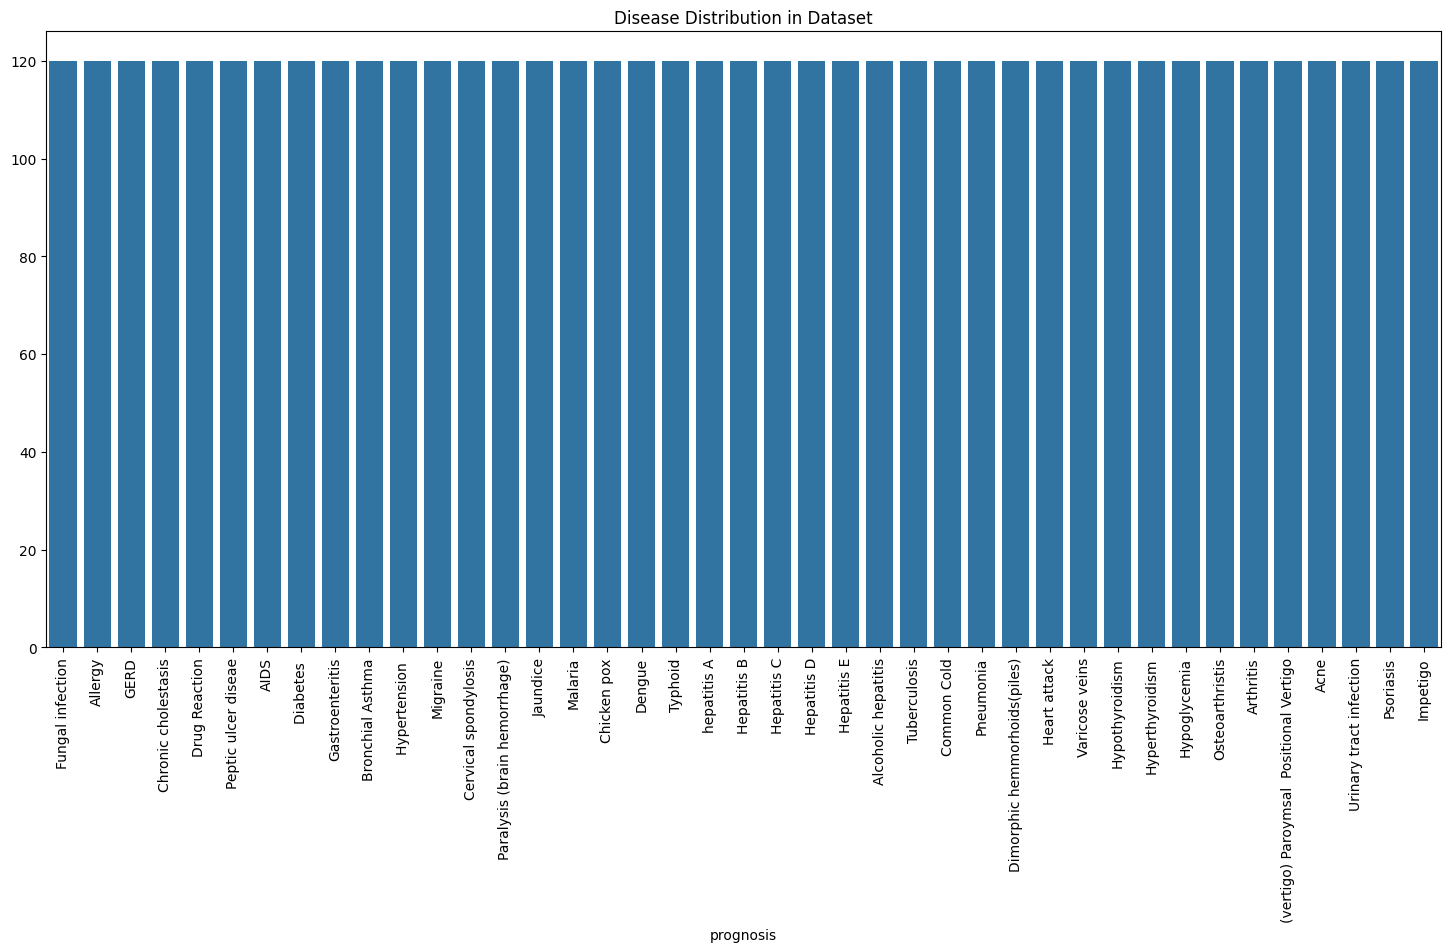

In [10]:
disease_counts = data["prognosis"].value_counts()
plt.figure(figsize=(18, 8))
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.xticks(rotation=90)
plt.title("Disease Distribution in Dataset")
plt.show()

data["prognosis"] = data["prognosis"].astype("category").cat.codes

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [11]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=18)
rf_search = RandomizedSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# GridSearchCV for fine-tuning Random Forest
rf_grid_params = {
    'n_estimators': [rf_search.best_params_['n_estimators'] - 50, rf_search.best_params_['n_estimators'], rf_search.best_params_['n_estimators'] + 50],
    'max_depth': [rf_search.best_params_['max_depth']],
    'min_samples_split': [rf_search.best_params_['min_samples_split'] - 1, rf_search.best_params_['min_samples_split'], rf_search.best_params_['min_samples_split'] + 1],
    'min_samples_leaf': [rf_search.best_params_['min_samples_leaf'] - 1, rf_search.best_params_['min_samples_leaf'], rf_search.best_params_['min_samples_leaf'] + 1]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=18), rf_grid_params, cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)
rf_best = rf_grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [12]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = xgb.XGBClassifier(**params, random_state=18)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

xgb_best = xgb.XGBClassifier(**study.best_params, random_state=18)
xgb_best.fit(X_train, y_train)

# Model Predictions
rf_preds = rf_best.predict(X_test)
xgb_preds = xgb_best.predict(X_test)

print(f"Tuned Random Forest Accuracy: {accuracy_score(y_test, rf_preds) * 100:.2f}%")
print(f"Tuned XGBoost Accuracy: {accuracy_score(y_test, xgb_preds) * 100:.2f}%")


[I 2025-03-27 13:46:02,316] A new study created in memory with name: no-name-5c2014ab-6b90-4f3a-b534-76c68dde15f5
<ipython-input-12-df58ad14366f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2025-03-27 13:46:13,727] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 240, 'max_depth': 5, 'learning_rate': 0.031062887939007043, 'subsample': 0.87468512077624, 'colsample_bytree': 0.7851153150779218, 'gamma': 1.8875433928375434, 'min_child_weight': 9}. Best is trial 0 with value: 1.0.
<ipython-input-12-df58ad14366f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': tri

Tuned Random Forest Accuracy: 100.00%
Tuned XGBoost Accuracy: 100.00%


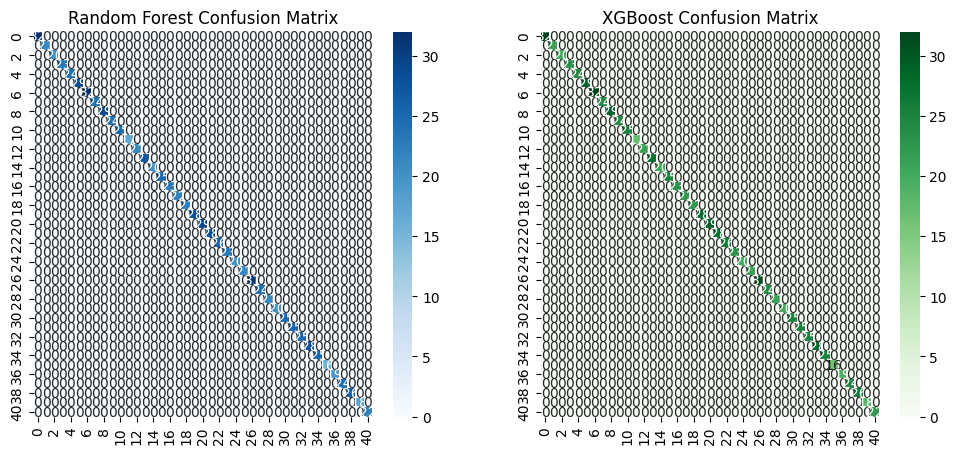

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()

100%|===================| 40330/40344 [19:39<00:00]       

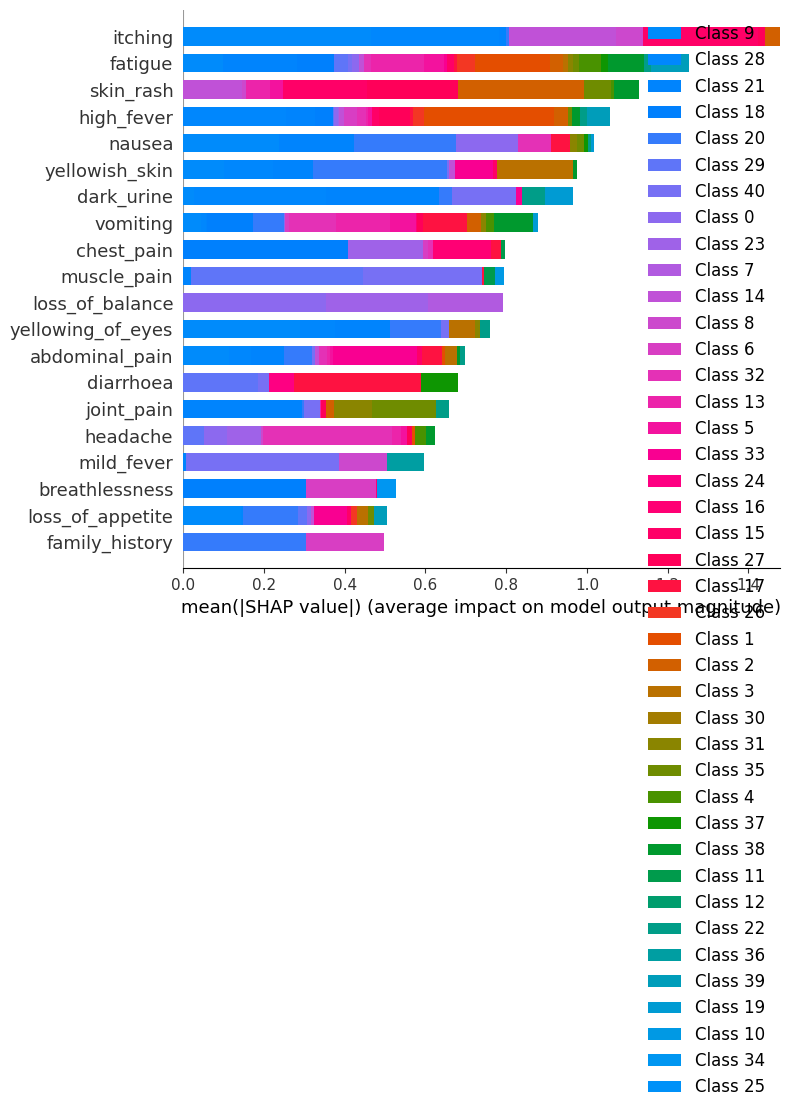

In [14]:
explainer = shap.Explainer(xgb_best, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [15]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4fe143512b3c0ab4b65469d8f2e073a896f56c99f0459ada6b776f1659555820
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [16]:
import lime
import lime.lime_tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['Disease'], mode='classification')
def explain_instance(instance_idx):
    exp = lime_explainer.explain_instance(X_test.iloc[instance_idx].values, xgb_best.predict_proba, num_features=10)
    exp.show_in_notebook()

display_idx = 0  # Change this index to test different examples
explain_instance(display_idx)

In [17]:
!pip install textblob


In [18]:
import nltk
nltk.download('brown')
nltk.download('punkt')


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
import numpy as np
import pandas as pd
import statistics
from sklearn.preprocessing import LabelEncoder
from rapidfuzz import process
from textblob import TextBlob

# Load and encode target labels
data = pd.read_csv("/content/Training.csv").dropna(axis=1)
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])  # Fit encoder on actual disease names

disease_mapping = dict(enumerate(encoder.classes_))  # Correct Disease Mapping
print("Correct Disease Encoding Mapping:", disease_mapping)  # Debugging

# Symptom Synonym Dictionary
symptom_synonyms = {
    "itch": "itching",
    "rash": "skin rash",
    "fatigue": "tiredness",
    "nausea": "vomiting",
    "headache": "migraine",
    "fever": "high temperature",
    "cold": "common cold",
    "cough": "persistent cough",
    "diarrhea": "loose stools",
    "sore throat": "throat pain"
}

def correct_spelling(symptom):
    return str(TextBlob(symptom).correct())

def fuzzy_match(symptom, symptom_list):
    match, score, _ = process.extractOne(symptom, symptom_list)  # Extract correct values
    return match if score > 80 else symptom  # Set threshold for matching

def preprocess_symptoms(symptoms):
    symptom_list = symptoms.split(",")
    processed_symptoms = []

    for symptom in symptom_list:
        symptom = correct_spelling(symptom.strip())  # Spell correction
        symptom = symptom_synonyms.get(symptom, symptom)  # Synonym replacement
        symptom = fuzzy_match(symptom, X.columns)  # Fuzzy matching with dataset columns
        processed_symptoms.append(symptom)

    return processed_symptoms

def predict_disease(symptoms, severities=None):
    symptom_list = preprocess_symptoms(symptoms)

    # Create a symptom vector with severity weights
    input_data = np.zeros(len(X.columns))
    for i, symptom in enumerate(symptom_list):
        if symptom in X.columns:
            index = X.columns.get_loc(symptom)
            severity = severities[i] if severities and i < len(severities) else 1  # Default severity 1
            input_data[index] = severity  # Assign severity score

    input_df = pd.DataFrame([input_data], columns=X.columns)

    # Model predictions (numerical labels)
    rf_prediction = rf_best.predict(input_df)[0]
    xgb_prediction = xgb_best.predict(input_df)[0]

    rf_disease = disease_mapping[rf_prediction]
    xgb_disease = disease_mapping[xgb_prediction]

    final_disease = statistics.mode([rf_disease, xgb_disease])

    return {
        "Random Forest Prediction": rf_disease,
        "XGBoost Prediction": xgb_disease,
        "Final Prediction": final_disease
    }

# Example real-time prediction with severity ratings
print(predict_disease("Itching, Skin Rash, Fatigue, Headache", [3, 5, 2, 4]))

Correct Disease Encoding Mapping: {0: '(vertigo) Paroymsal  Positional Vertigo', 1: 'AIDS', 2: 'Acne', 3: 'Alcoholic hepatitis', 4: 'Allergy', 5: 'Arthritis', 6: 'Bronchial Asthma', 7: 'Cervical spondylosis', 8: 'Chicken pox', 9: 'Chronic cholestasis', 10: 'Common Cold', 11: 'Dengue', 12: 'Diabetes ', 13: 'Dimorphic hemmorhoids(piles)', 14: 'Drug Reaction', 15: 'Fungal infection', 16: 'GERD', 17: 'Gastroenteritis', 18: 'Heart attack', 19: 'Hepatitis B', 20: 'Hepatitis C', 21: 'Hepatitis D', 22: 'Hepatitis E', 23: 'Hypertension ', 24: 'Hyperthyroidism', 25: 'Hypoglycemia', 26: 'Hypothyroidism', 27: 'Impetigo', 28: 'Jaundice', 29: 'Malaria', 30: 'Migraine', 31: 'Osteoarthristis', 32: 'Paralysis (brain hemorrhage)', 33: 'Peptic ulcer diseae', 34: 'Pneumonia', 35: 'Psoriasis', 36: 'Tuberculosis', 37: 'Typhoid', 38: 'Urinary tract infection', 39: 'Varicose veins', 40: 'hepatitis A'}
{'Random Forest Prediction': 'Fungal infection', 'XGBoost Prediction': 'Fungal infection', 'Final Prediction'

In [15]:
print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))


{'Random Forest Prediction': 'Fungal infection', 'XGBoost Prediction': 'Chronic cholestasis', 'Final Prediction': 'Fungal infection'}


In [16]:
import joblib

# Save models in Colab
joblib.dump(rf_best, "/content/rf_model.pkl")
joblib.dump(xgb_best, "/content/xgb_model.pkl")

# Save encoder
joblib.dump(encoder, "/content/encoder.pkl")


['/content/encoder.pkl']

In [ ]:
from google.colab import files

# Download models to local system
files.download("/content/rf_model.pkl")
files.download("/content/xgb_model.pkl")
files.download("/content/encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
!pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.8 MB/s eta 0:00:00


In [17]:
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder
from rapidfuzz import process
from textblob import TextBlob
import os

app = Flask(__name__)

# Load trained models and encoder
MODEL_DIR = os.getcwd()  # Get current directory
rf_model = joblib.load(os.path.join(MODEL_DIR, "rf_model.pkl"))
xgb_model = joblib.load(os.path.join(MODEL_DIR, "xgb_model.pkl"))
encoder = joblib.load(os.path.join(MODEL_DIR, "encoder.pkl"))

# Load dataset to get symptom columns
data = pd.read_csv(os.path.join(MODEL_DIR, "Training.csv")).dropna(axis=1)
symptom_columns = data.columns[:-1]  # All symptoms (excluding "prognosis")

# Map encoded diseases back to names
disease_mapping = dict(enumerate(encoder.classes_))

# Synonym Dictionary for symptoms
symptom_synonyms = {
    "itch": "itching",
    "rash": "skin rash",
    "fatigue": "tiredness",
    "nausea": "vomiting",
    "headache": "migraine",
    "fever": "high temperature",
    "cold": "common cold",
    "cough": "persistent cough",
    "diarrhea": "loose stools",
    "sore throat": "throat pain"
}

# 🔹 Function to correct spelling
def correct_spelling(symptom):
    return str(TextBlob(symptom).correct())

# 🔹 Function to fuzzy match symptom names
def fuzzy_match(symptom):
    match, score, _ = process.extractOne(symptom, symptom_columns)
    return match if score > 80 else None  # Set 80% confidence threshold

# 🔹 Function to process symptoms before prediction
def preprocess_symptoms(symptoms):
    processed_symptoms = []

    for symptom in symptoms:
        symptom = symptom.strip().lower()  # Clean text
        symptom = correct_spelling(symptom)  # Correct spelling
        symptom = symptom_synonyms.get(symptom, symptom)  # Replace synonym
        matched_symptom = fuzzy_match(symptom)  # Match with dataset columns
        if matched_symptom:
            processed_symptoms.append(matched_symptom)

    return processed_symptoms

# 🔹 Prediction Function
def predict_disease(symptoms, severities=None):
    processed_symptoms = preprocess_symptoms(symptoms)
    print("🔍 Processed Symptoms:", processed_symptoms)  # Debugging

    input_data = np.zeros(len(symptom_columns))
    for i, symptom in enumerate(processed_symptoms):
        if symptom in symptom_columns:
            index = list(symptom_columns).index(symptom)  # Fixed get_loc issue
            severity = severities[i] if severities and i < len(severities) else 1
            input_data[index] = severity

    input_df = pd.DataFrame([input_data], columns=symptom_columns)
    print("🔹 Model Input Data:\n", input_df)  # Debugging

    rf_prediction = rf_model.predict(input_df)[0]
    xgb_prediction = xgb_model.predict(input_df)[0]

    rf_disease = disease_mapping[rf_prediction]
    xgb_disease = disease_mapping[xgb_prediction]

    print(f"🟢 RF: {rf_disease}, 🔵 XGB: {xgb_disease}")  # Debugging

    final_disease = statistics.mode([rf_disease, xgb_disease])

    return {
        "Random Forest Prediction": rf_disease,
        "XGBoost Prediction": xgb_disease,
        "Final Prediction": final_disease
    }

# 🔥 Flask API Endpoint for Disease Prediction
@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    symptoms = data.get("symptoms", [])  # Expecting list instead of a string
    severities = data.get("severities", None)  # Optional severity list

    if not symptoms:
        return jsonify({"error": "No symptoms provided"}), 400

    prediction = predict_disease(symptoms, severities)
    return jsonify(prediction)

# Run Flask App
if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
